# Imports

In [251]:
%pip install tensorflow==2.16.1 --quiet

In [252]:
import tensorflow as tf
import numpy as np
import matplotlib

In [253]:
tf.__version__, np.__version__, matplotlib.__version__

('2.16.1', '1.26.4', '3.8.0')

In [ ]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras import utils as keras_utils
from tensorflow.keras.callbacks import CSVLogger
import matplotlib.pyplot as plt

# Database

## Download the databased

In [255]:
(x_train, y_train), (x_test, y_test) =  mnist.load_data()
print(f"""
  null values:
  x_train: {np.isnan(x_train).sum()}
  y_train: {np.isnan(y_train).sum()}
  x_test: {np.isnan(x_test).sum()}
  y_test: {np.isnan(y_test).sum()}    
  
  Shapes:
  x_train: {x_train.shape}
  y_train: {y_train.shape}
  x_test: {x_test.shape}
  y_test: {y_test.shape}
  
  Max/Min values:
  x_train: {x_train.max()}\{x_train.min()}
  y_train: {y_train.max()}\{y_train.min()}
  x_test: {x_test.max()}\{x_test.min()}
  y_test: {y_test.max()}\{y_test.min()}
""")


  null values:
  x_train: 0
  y_train: 0
  x_test: 0
  y_test: 0    
  
  Shapes:
  x_train: (60000, 28, 28)
  y_train: (60000,)
  x_test: (10000, 28, 28)
  y_test: (10000,)
  
  Max/Min values:
  x_train: 255\0
  y_train: 9\0
  x_test: 255\0
  y_test: 9\0



## Preprocessing

### Normalization

In [256]:
x_train, x_test = x_train / x_train[0].max(), x_test / x_test[0].max()
print(f"Min/Max: x_train={x_train[0].max()}/{x_train[0].min()}, x_test={x_test[0].max()}/{x_test[0].min()}")

Min/Max: x_train=1.0/0.0, x_test=1.0/0.0


### Train-test flatten

In [257]:
x_train_flatten = x_train.reshape(-1, np.prod(x_train.shape[1:]))
x_test_flatten = x_test.reshape(-1, np.prod(x_test.shape[1:]))
x_train_flatten.shape, x_test_flatten.shape

((60000, 784), (10000, 784))

### Train-test conv

In [289]:
x_train_conv, x_test_conv = x_train[..., np.newaxis], x_test[..., np.newaxis]
x_train_conv.shape, x_test_conv.shape

((60000, 28, 28, 1), (10000, 28, 28, 1))

### test categories

In [258]:
y_train, y_test = keras_utils.to_categorical(y_train), keras_utils.to_categorical(y_test)
y_train.shape, y_test.shape

((60000, 10), (10000, 10))

# Visualizing Image Dimensionality Reduction

In [259]:
QTD_NEURO_ENCODER = 128

## Building and Training the Model

In [260]:
autoencoder_falleng = Sequential()
autoencoder_falleng.add(Input(shape=(x_train_flatten.shape[1],)))
autoencoder_falleng.add(Dense(QTD_NEURO_ENCODER, activation='relu'))
autoencoder_falleng.add(Dense(x_train_flatten.shape[1], activation='sigmoid'))
autoencoder_falleng.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [261]:
%%time
csv_logger_autoencor_falleng = CSVLogger('csv_logger_autoencor_falleng.csv', append=False)

autoencoder_falleng.fit(
  x_train_flatten, x_train_flatten,
  epochs=50, batch_size=256, verbose=0,
  callbacks=[csv_logger_autoencor_falleng],
  validation_data=(x_test_flatten, x_test_flatten)
)

CPU times: user 45.5 s, sys: 11 s, total: 56.5 s
Wall time: 48.2 s


In [262]:
img_flatten = Input(shape=(x_train_flatten.shape[1],))
img_encoded_flatten = Input(shape=(QTD_NEURO_ENCODER,))
encoder_flatting = Model(img_flatten, autoencoder_falleng.layers[0](img_flatten))
decoder_flatting = Model(img_encoded_flatten, autoencoder_falleng.layers[-1](img_encoded_flatten))

## Predictions

In [263]:
imgs_encoded_flatting = encoder_flatting.predict(x_test_flatten)
imgs_decoded_flatting = decoder_flatting.predict(imgs_encoded_flatting)
imgs_encoded_flatting.shape, imgs_decoded_flatting.shape

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


((10000, 128), (10000, 784))

## Visualizing the Results

Encoded size: 4.88 MB -> Predicted size: 29.91 MB. Reduction size: 25.02 MB
Percentage reduction: 83.67%
Similarity percentage: 98.78%


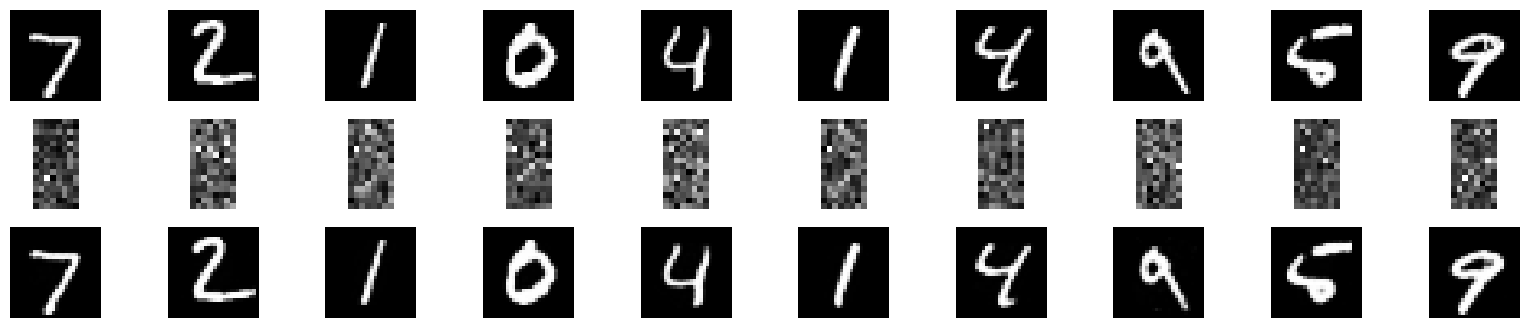

In [264]:
size_encoded = imgs_encoded_flatting.__sizeof__()
size_pred = imgs_decoded_flatting.__sizeof__()
size_encoded_mb = size_encoded / 1024 / 1024
size_pred_mb = size_pred / 1024 / 1024
reduction_size = abs(size_encoded_mb - size_pred_mb)
reduction_rate = size_pred_mb / size_encoded_mb
percentage_reduction = (1 - (size_encoded_mb / size_pred_mb)) * 100
mean_diff = np.mean(np.abs(x_test_flatten - imgs_decoded_flatting))
similarity_percentage = (1 - mean_diff) * 100

print(f"Encoded size: {size_encoded_mb:.2f} MB -> Predicted size: {size_pred_mb:.2f} MB. Reduction size: {reduction_size:.2f} MB")
print(f"Percentage reduction: {percentage_reduction:.2f}%")
print(f"Similarity percentage: {similarity_percentage:.2f}%")

QTD_IMGS = 10
plt.figure(figsize=(20, 4))
for i in range(QTD_IMGS):
  # Original images
  plt.subplot(3, QTD_IMGS, i + 1)
  plt.imshow(x_test[i], cmap='gray')
  plt.axis('off')
  
  # Encoded images
  plt.subplot(3, QTD_IMGS, i + QTD_IMGS + 1)
  plt.imshow(imgs_encoded_flatting[i].reshape(16, 8), cmap='gray')
  plt.axis('off')
  
  # Reconstructed images
  plt.subplot(3, QTD_IMGS, i + 2 * QTD_IMGS + 1)
  plt.imshow(imgs_decoded_flatting[i].reshape(28, 28), cmap='gray')
  plt.axis('off')
  
plt.show()

# Visualizing Image Dimensionality Reduction - Categorical

## Building and Training the Model

In [265]:
QTD_NEURO_ENCODER = 32

#### Encoding Model

In [266]:
autoencoder_falleng_2 = Sequential()
autoencoder_falleng_2.add(Input(shape=(x_train_flatten.shape[1],)))
autoencoder_falleng_2.add(Dense(QTD_NEURO_ENCODER, activation='relu'))
autoencoder_falleng_2.add(Dense(x_train_flatten.shape[1], activation='sigmoid'))
autoencoder_falleng_2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [267]:
%%time
csv_logger_autoencor_falleng_2 = CSVLogger('csv_logger_autoencor_falleng_2.csv', append=False)

autoencoder_falleng_2.fit(
  x_train_flatten, x_train_flatten,
  epochs=50, batch_size=256, verbose=0,
  callbacks=[csv_logger_autoencor_falleng_2]
);

CPU times: user 38.1 s, sys: 9.17 s, total: 47.3 s
Wall time: 34.8 s


In [268]:
img_flatten_2 = Input(shape=(x_train_flatten.shape[1],))
img_encoded_flatten_2 = Input(shape=(QTD_NEURO_ENCODER,))
encoder_flatting_2 = Model(img_flatten_2, autoencoder_falleng_2.layers[0](img_flatten_2))
decoder_flatting_2 = Model(img_encoded_flatten_2, autoencoder_falleng_2.layers[-1](img_encoded_flatten_2))

#### Category Models

In [269]:
units_count = int((x_train_flatten.shape[1] + y_train.shape[1]) / 2)

In [270]:
network_no_encoded = Sequential()
network_no_encoded.add(Input(shape=(x_train_flatten.shape[1],)))
network_no_encoded.add(Dense(units_count, activation='relu'))
network_no_encoded.add(Dense(units_count, activation='relu'))
network_no_encoded.add(Dense(10, activation='softmax'))
network_no_encoded.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
params_no_encoded = network_no_encoded.count_params()
params_no_encoded

473631

In [271]:
%%time
cv2_logger_classifier_no_encoded = CSVLogger('cv2_logger_classifier_no_encoded.csv', append=False)
es = EarlyStopping(monitor='val_loss', min_delta=1e-10, patience=10)
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5)

network_no_encoded.fit(
    x_train_flatten, y_train, 
    epochs=50, batch_size=256, verbose=0,
    callbacks=[cv2_logger_classifier_no_encoded, es, rlr],
    validation_data=(x_test_flatten, y_test),
);

CPU times: user 23.8 s, sys: 4.62 s, total: 28.4 s
Wall time: 23.2 s


In [272]:
units_count = int((QTD_NEURO_ENCODER + y_train.shape[1]) / 2)

In [273]:
network_encoded = Sequential()
network_encoded.add(Input(shape=(QTD_NEURO_ENCODER,)))
network_encoded.add(Dense(units_count, activation='relu'))
network_encoded.add(Dense(units_count, activation='relu'))
network_encoded.add(Dense(10, activation='softmax'))
network_encoded.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
params_encoded = network_encoded.count_params()
params_encoded

1375

In [274]:
%%time
cv2_logger_classifier_encoded = CSVLogger('cv2_logger_classifier_encoded.csv', append=False)
es = EarlyStopping(monitor='val_loss', min_delta=1e-10, patience=10)
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5)


network_encoded.fit(
  encoder_flatting_2.predict(x_train_flatten), y_train, 
  epochs=100, batch_size=256, verbose=0, 
  callbacks=[cv2_logger_classifier_encoded, es, rlr],
  validation_data=(encoder_flatting_2.predict(x_test_flatten), y_test)
);

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
CPU times: user 56.2 s, sys: 12.7 s, total: 1min 8s
Wall time: 1min 3s


## Predictions

In [275]:
imgs_encoded_x_train_flatting_2 = encoder_flatting_2.predict(x_train_flatten)
imgs_encoded_x_test_flatting_2 = encoder_flatting_2.predict(x_test_flatten)
imgs_decoded_x_train_flatting_2 = decoder_flatting_2.predict(imgs_encoded_x_train_flatting_2)
imgs_decoded_x_test_flatting_2 = decoder_flatting_2.predict(imgs_encoded_x_test_flatting_2)

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [276]:
%%time
predicitions_no_encoded_categorical = network_no_encoded.predict(x_test_flatten)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
CPU times: user 1.47 s, sys: 229 ms, total: 1.7 s
Wall time: 1.75 s


In [277]:
%%time
temp = encoder_flatting_2.predict(x_test_flatten)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
CPU times: user 711 ms, sys: 213 ms, total: 924 ms
Wall time: 895 ms


In [278]:
%time
predicitions_encoded_categorical = network_encoded.predict(temp)

CPU times: user 7 µs, sys: 1e+03 ns, total: 8 µs
Wall time: 14.8 µs
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


In [279]:
predicitions_no_encoded = np.argmax(predicitions_no_encoded_categorical, axis=1)
predicitions_encoded = np.argmax(predicitions_encoded_categorical, axis=1)
predicitions_no_encoded[:10], predicitions_encoded[:10], np.argmax(y_test[:10], axis=1)

(array([7, 2, 1, 0, 4, 1, 4, 9, 5, 9]),
 array([7, 2, 1, 0, 4, 1, 4, 9, 2, 9]),
 array([7, 2, 1, 0, 4, 1, 4, 9, 5, 9]))

## Visualizing the Results

Encoded size: 1.22 MB -> Predicted size: 29.91 MB. Reduction size: 28.69 MB
Percentage reduction: 95.92%
Similarity percentage: 96.75%
No encoded params: 473631 -> Encoded params: 1375. Reduction: 99.71%


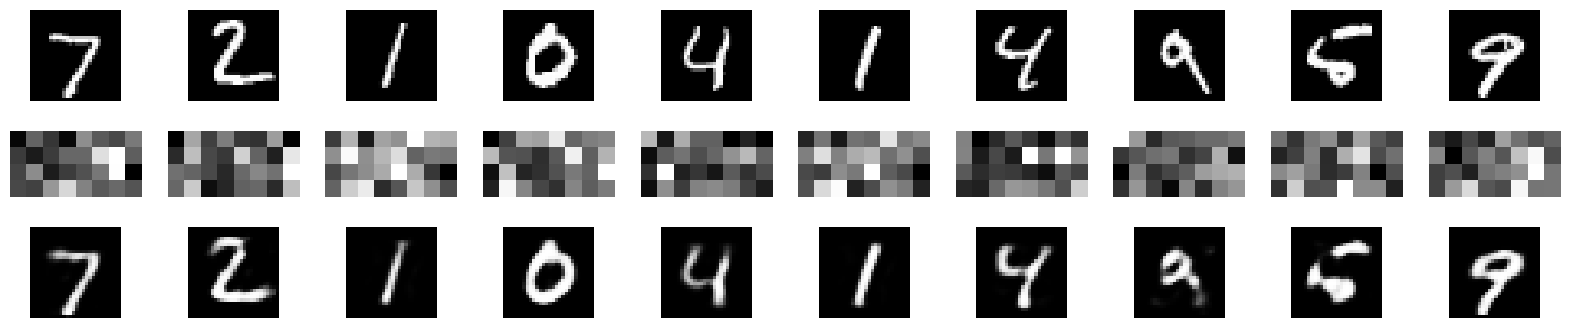

In [280]:
size_encoded = imgs_encoded_x_test_flatting_2.__sizeof__()
size_pred = imgs_decoded_x_test_flatting_2.__sizeof__()
size_encoded_mb = size_encoded / 1024 / 1024
size_pred_mb = size_pred / 1024 / 1024
reduction_size = abs(size_encoded_mb - size_pred_mb)
reduction_rate = size_pred_mb / size_encoded_mb
percentage_reduction = (1 - (size_encoded_mb / size_pred_mb)) * 100
mean_diff = np.mean(np.abs(x_test_flatten - imgs_decoded_x_test_flatting_2))
similarity_percentage = (1 - mean_diff) * 100
reduction_porcentage = (1 - (params_encoded / params_no_encoded)) * 100


print(f"Encoded size: {size_encoded_mb:.2f} MB -> Predicted size: {size_pred_mb:.2f} MB. Reduction size: {reduction_size:.2f} MB")
print(f"Percentage reduction: {percentage_reduction:.2f}%")
print(f"Similarity percentage: {similarity_percentage:.2f}%")
print(f"No encoded params: {params_no_encoded} -> Encoded params: {params_encoded}. Reduction: {reduction_porcentage:.2f}%")


QTD_IMGS = 10
plt.figure(figsize=(20, 4))
for i in range(QTD_IMGS):
  # Original images
  plt.subplot(3, QTD_IMGS, i + 1)
  plt.imshow(x_test[i], cmap='gray')
  plt.axis('off')
  
  # Encoded images
  plt.subplot(3, QTD_IMGS, i + QTD_IMGS + 1)
  plt.imshow(imgs_encoded_x_test_flatting_2[i].reshape(4, 8), cmap='gray')
  plt.axis('off')
  
  # Reconstructed images
  plt.subplot(3, QTD_IMGS, i + 2 * QTD_IMGS + 1)
  plt.imshow(imgs_decoded_x_test_flatting_2[i].reshape(28, 28), cmap='gray')
  plt.axis('off')
  
plt.show()

In [281]:
accuracy_no_encoded = np.mean(predicitions_no_encoded == np.argmax(y_test, axis=1))
accuracy_encoded = np.mean(predicitions_encoded == np.argmax(y_test, axis=1))

print(f"Accuracy no encoded: {accuracy_no_encoded:.2f} -> Accuracy encoded: {accuracy_encoded:.2f}")
print(f"Accuracy difference: {abs(accuracy_encoded - accuracy_no_encoded):.2f}")

Accuracy no encoded: 0.98 -> Accuracy encoded: 0.96
Accuracy difference: 0.03


# Visualizing Image Dimensionality Reduction - Deep Learning

## Building and Training the Model

In [282]:
units_count = int((x_train_flatten.shape[1] + y_train.shape[1]) / 2)
QTD_NEURO_ENCODER = 32
QTD_NEURO_ENCODER, units_count

(32, 397)

In [283]:
autoencoder_flattening_deep = Sequential()
autoencoder_flattening_deep.add(Input(shape=(x_train_flatten.shape[1],)))
autoencoder_flattening_deep.add(Dense(units_count, activation='relu'))
autoencoder_flattening_deep.add(Dense(int(units_count / 2), activation='relu'))
autoencoder_flattening_deep.add(Dense(int(units_count / 4), activation='relu'))
autoencoder_flattening_deep.add(Dense(QTD_NEURO_ENCODER, activation='relu'))
autoencoder_flattening_deep.add(Dense(int(units_count / 4), activation='relu'))
autoencoder_flattening_deep.add(Dense(int(units_count / 2), activation='relu'))
autoencoder_flattening_deep.add(Dense(units_count, activation='relu'))
autoencoder_flattening_deep.add(Dense(x_train_flatten.shape[1], activation='sigmoid'))
autoencoder_flattening_deep.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [284]:
input_flatten_deep = Input(shape=(x_train_flatten.shape[1],))
camada_1_deep = autoencoder_flattening_deep.layers[0](input_flatten_deep)
camada_2_deep = autoencoder_flattening_deep.layers[1](camada_1_deep)
camada_3_deep = autoencoder_flattening_deep.layers[2](camada_2_deep)
encoder_flatting_deep = Model(input_flatten_deep, autoencoder_flattening_deep.layers[3](camada_3_deep))

In [285]:
input_encoded_deep = Input(shape=(QTD_NEURO_ENCODER,))
camada_4_deep = autoencoder_flattening_deep.layers[4](input_encoded_deep)
camada_5_deep = autoencoder_flattening_deep.layers[5](camada_4_deep)
camada_6_deep = autoencoder_flattening_deep.layers[6](camada_5_deep)
decoder_flatting_deep = Model(input_encoded_deep, autoencoder_flattening_deep.layers[-1](camada_6_deep))

In [286]:
cv2_logger_autoencor_falleng_deep = CSVLogger('cv2_logger_autoencor_falleng_deep.csv', append=False)

autoencoder_flattening_deep.fit(
  x_train_flatten, x_train_flatten,
  epochs=50, batch_size=256, verbose=0,
  callbacks=[cv2_logger_autoencor_falleng_deep],
  validation_data=(x_test_flatten, x_test_flatten)
)

In [287]:
imgs_encoded_x_test_flatting_deep = encoder_flatting_deep.predict(x_test_flatten)
imgs_decoded_x_test_flatting_deep = decoder_flatting_deep.predict(imgs_encoded_x_test_flatting_deep)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 495us/step


Encoded size: 1.22 MB -> Predicted size: 29.91 MB. Reduction size: 28.69 MB
Percentage reduction: 95.92%
Similarity percentage: 97.63%


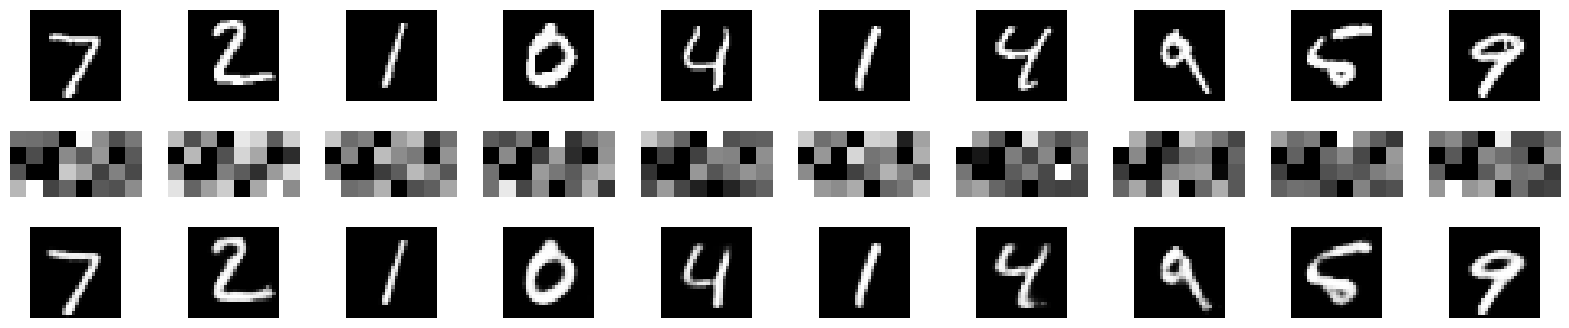

In [288]:
size_encoded = imgs_encoded_x_test_flatting_deep.__sizeof__()
size_pred = imgs_decoded_x_test_flatting_deep.__sizeof__()

size_encoded_mb = size_encoded / 1024 / 1024
size_pred_mb = size_pred / 1024 / 1024

reduction_size = abs(size_encoded_mb - size_pred_mb)
percentage_reduction = (1 - (size_encoded_mb / size_pred_mb)) * 100
similarity_percentage = (1 - np.mean(np.abs(x_test_flatten - imgs_decoded_x_test_flatting_deep))) * 100

print(f"Encoded size: {size_encoded_mb:.2f} MB -> Predicted size: {size_pred_mb:.2f} MB. Reduction size: {reduction_size:.2f} MB")
print(f"Percentage reduction: {percentage_reduction:.2f}%")
print(f"Similarity percentage: {similarity_percentage:.2f}%")


QTD_IMGS = 10
plt.figure(figsize=(20, 4))
for i in range(QTD_IMGS):
  # Original images
  plt.subplot(3, QTD_IMGS, i + 1)
  plt.imshow(x_test[i], cmap='gray')
  plt.axis('off')
  
  # Encoded images
  plt.subplot(3, QTD_IMGS, i + QTD_IMGS + 1)
  plt.imshow(imgs_encoded_x_test_flatting_deep[i].reshape(4, 8), cmap='gray')
  plt.axis('off')
  
  # Reconstructed images
  plt.subplot(3, QTD_IMGS, i + 2 * QTD_IMGS + 1)
  plt.imshow(imgs_decoded_x_test_flatting_deep[i].reshape(28, 28), cmap='gray')
  plt.axis('off')
  
plt.show()

# Visualizing Image Dimensionality Reduction - Convolutional Neural Networks